# Dataprep

### Load data

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
book = np.loadtxt("data/GoT_parsed/Game Of Thrones - George R. R. Martin.txt")
book.shape

(23924,)

In [3]:
books_data = np.load('data/bok.npz', allow_pickle=True)['arr_0']
type(books_data)

numpy.ndarray

In [4]:
max_len = np.max([book.shape[0] for book in books_data])
max_len

36122

### Unify data

stretch sequences to the length of the longest sequence:

In [5]:
from random import sample

def stretch(max_len, arr):
    """
    Stretches an array to the max_len by
    inserting mean of neighbours enough times
    """
    diff = max_len-len(arr)
    inds = np.random.choice(len(arr)-1, diff, replace=True)
    inds.sort()
    inds = np.flip(inds, 0)
    for i in inds:
        ins_value = (arr[i] + arr[i+1]) / 2
        arr = np.concatenate((arr[:i+1], [ins_value], arr[i+1:]))
    return arr
        

In [6]:
books_data = [stretch(max_len, i) for i in books_data]

In [7]:
for i in books_data:
    print(len(i))

36122
36122
36122
36122
36122


# Clustering

In [8]:
from sklearn.cluster import DBSCAN, KMeans
books_data = np.array(books_data)[:,:,0]

In [9]:
books_data.shape

(5, 36122)

### K-means

#### elbow method to determine K:

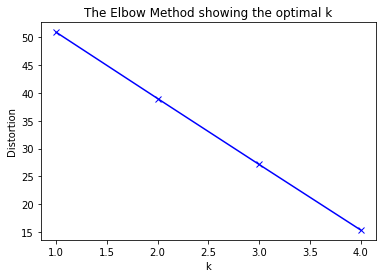

In [10]:
from sklearn import metrics
from scipy.spatial.distance import cdist
import matplotlib.pyplot as plt

# k means determine k
distortions = []
K = range(1,5)
for k in K:
    kmeanModel = KMeans(n_clusters=k).fit(books_data)
    kmeanModel.fit(books_data)
    distortions.append(sum(np.min(cdist(books_data, kmeanModel.cluster_centers_, 'euclidean'), axis=1)) / books_data.shape[0])

# Plot the elbow
plt.plot(K, distortions, 'bx-')
plt.xlabel('k')
plt.ylabel('Distortion')
plt.title('The Elbow Method showing the optimal k')
plt.show()

#### Cluster:

In [11]:
kmeans = KMeans(n_clusters=3, random_state=0).fit(books_data)
kmeans_pred = kmeans.predict(books_data)
kmeans_pred

array([1, 1, 2, 1, 0], dtype=int32)

In [12]:
kmeans.cluster_centers_

array([[0.5862422 , 0.4663363 , 0.9049411 , ..., 0.65850824, 0.96224445,
        0.7226514 ],
       [0.34015834, 0.4574873 , 0.5159915 , ..., 0.83261997, 0.50801617,
        0.7337741 ],
       [0.40999895, 0.4663363 , 0.9681783 , ..., 0.19835228, 0.15062296,
        0.1103493 ]], dtype=float32)

#### visualize with T-SNE

In [13]:
from sklearn.manifold import TSNE

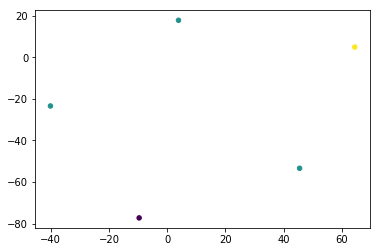

In [14]:
# Setting plotting parameters
tsne = TSNE(n_components=2, n_iter = 300, random_state=0)
# np.set_printoptions(suppress=True)
books_tsne = tsne.fit_transform(books_data)
plt.scatter(books_tsne[:,0], books_tsne[:,1], s=20, c=kmeans_pred);
plt.show()

#### Evaluation

In [20]:
from sklearn.metrics import davies_bouldin_score, silhouette_samples, silhouette_score

* DBi

The DB index captures the intuition that clusters that are (1) well-spaced from each other and (2) themselves very dense are likely a ‘good’ clustering. This is because the measure’s ‘max’ statement repeatedly selects the values where the average point is farthest away from its centroid, and where the centroids are closest together. As the DB index shrinks, the clustering is considered ‘better’.

In [19]:
davies_bouldin_score(books_data, kmeans_pred)

0.6748956409482508

* Silhouette Coefficient

The Silhouette Coefficient tells us how well-assigned each individual point is. If S(i) is close to 0, it is right at the inflection point between two clusters. If it is closer to -1, then we would have been better off assigning it to the other cluster. If S(i) is close to 1, then the point is well-assigned and can be interpreted as belonging to an ‘appropriate’ cluster.

The Silhouette Coefficient is a measure of how well samples are clustered with samples that are similar to themselves. Clustering models with a high Silhouette Coefficient are said to be dense, where samples in the same cluster are similar to each other, and well separated, where samples in different clusters are not very similar to each other.

The Silhouette Coefficient is calculated using the mean intra-cluster distance (a) and the mean nearest-cluster distance (b) for each sample. The Silhouette Coefficient for a sample is (b - a) / max(a, b). Note that Silhouette Coefficient is only defined if number of labels is 2 <= n_labels <= n_samples - 1.

The best value is 1 and the worst value is -1. Values near 0 indicate overlapping clusters.

In [21]:
silhouette_score(books_data, kmeans_pred)

0.017241841

In [23]:
silhouette_samples(books_data, kmeans_pred)

array([0.03451678, 0.03517154, 0.        , 0.01652089, 0.        ],
      dtype=float32)

### DBSCAN

#### Cluster:

In [257]:
dbscan = DBSCAN(eps=3, min_samples=2).fit(books_data)

In [258]:
dbscan.labels_

array([-1, -1, -1, -1, -1])

#### Evaluation

# Models comparison & conclusions